# Canny Edge Detector

The Canny Edge detector is named after its inventor, John F. Canny. It is among the most popular edge detection algorithms due to its simplicity and effectiveness. The algorithm uses gradient information to detect edges. It follow the following steps:


### 1. **Smoothing or Noise Reduction** : 

The algorithm uses a Gaussian filter to smooth the image and reduce noise. This is done to prevent the algorithm from detecting false edges due to noise. It also smoothens the image to reduce the abrupt changes in pixel values. These abrupt changes may end up being detected as edges.

$$I'(x,y) = G(x,y) * I(x,y)$$

where $I(x,y)$ is the input image, $G(x,y)$ is the Gaussian filter and $I'(x,y)$ is the smoothed image. '*' represents convolution operation between the image and the filter. Reading the image and convert it to grayscale. Image is converted to grayscale because the edge detection is done on the intensity values of the image. The color information is not required for edge detection. 


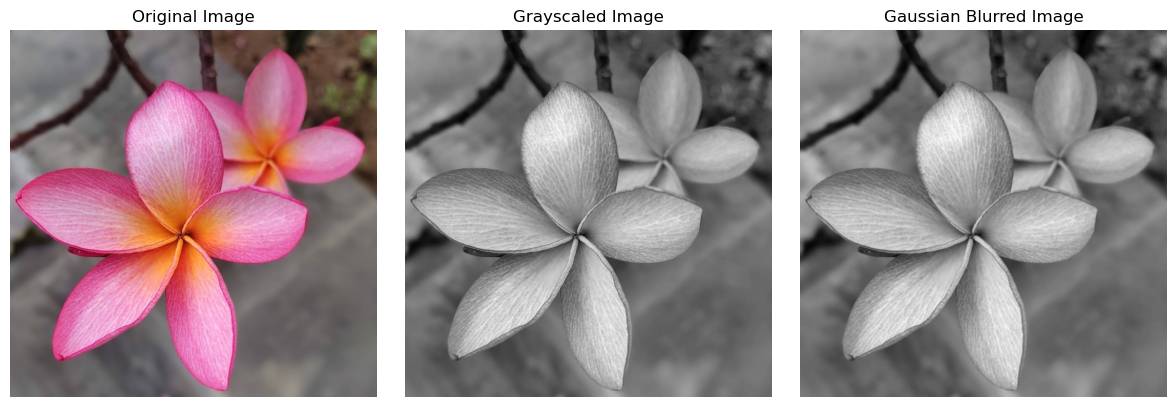

In [ ]:
# Importing libraries 
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Read the image
image = cv.imread('Flower.jpeg')

plt.figure(figsize=(12, 4))
# Convert the image to RGB (OpenCV loads it into BGR by default)
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')

# Convert the image to grayscale
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
plt.subplot(1, 3, 2)
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.title('Grayscaled Image')

# Apply Gaussian Blur
blurred_image = cv.GaussianBlur(gray_image, (3, 3), 0)
plt.subplot(1, 3, 3)
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')
plt.title('Gaussian Blurred Image')

plt.tight_layout()
plt.show()

### 2. **Gradient Calculation** : 

The algorithm then calculates the gradient of the image. The gradient is calculated using the Sobel operator. The Sobel operator is a discrete differentiation operator. It computes an approximation of gradient of the image. The operator uses two 3x3 kernels which are convolved with the original image to calculate approximations of the derivatives - one for horizontal changes, and one for vertical. $G_x$ and $G_y$ are the horizontal and vertical Sobel operators respectively.

$$G_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$
$$G_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}$$

$$I_y = I' * G_y$$
$$I_x = I' * G_x$$

where $I_x$ and $I_y$ are the horizontal and vertical gradients respectively. 

Now the combined gradient magnitude could be calculated using two methods. 
* Using L1 Norm: 
    
$$Magnitude = |I_x| + |I_y|$$

* Using L2 Norm: 
    
$$Magnitude =  \sqrt{I_x^2 + I_y^2}$$


$$Direction = \arctan(\frac{I_y}{I_x})$$


Magnitude signifies the strength of the edge. The direction is the angle of the edge. The direction is rounded to one of four angles representing vertical, horizontal and two diagonals. The angles are 0, 45, 90 and 135 degrees. We are assuming the edges are in one of these four directions.

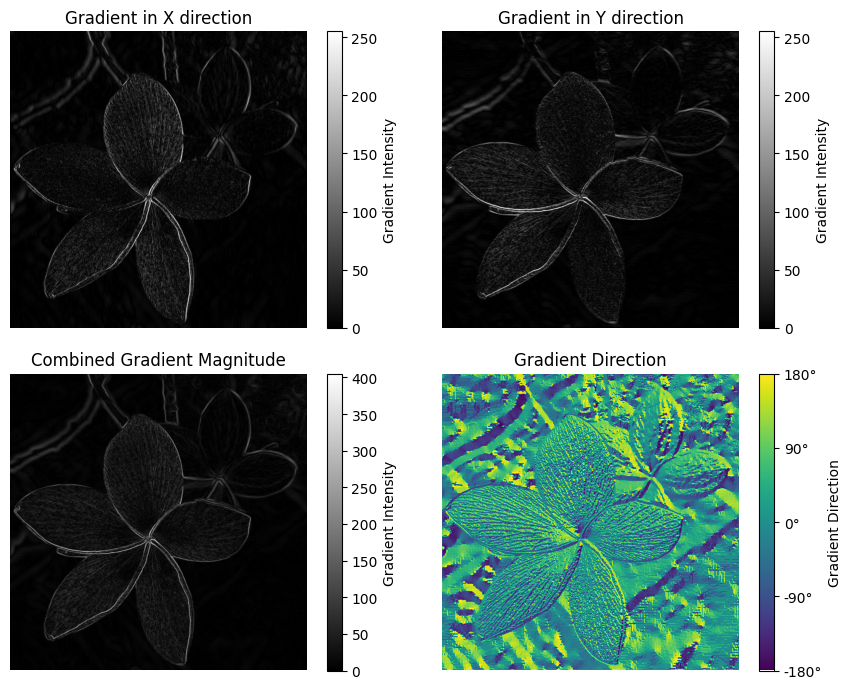

In [38]:
# Compute the gradients by applying Sobel operator
I_x = cv.Sobel(blurred_image, cv.CV_64F, 1, 0, ksize=3)
I_y = cv.Sobel(blurred_image, cv.CV_64F, 0, 1, ksize=3)

# Compute the magnitude of the gradients
magnitude = np.sqrt(I_x**2 + I_y**2)

# Compute the magnitude of the gradients using the L1 norm
# magnitude = np.abs(I_x) + np.abs(I_y)

direction = np.arctan2(I_y, I_x)

plt.figure(figsize=(9, 7))

plt.subplot(2, 2, 1)
plt.imshow(cv.convertScaleAbs(I_x), cmap='gray')
plt.axis('off')
plt.title('Gradient in X direction')
cbar = plt.colorbar()
cbar.set_label('Gradient Intensity')

plt.subplot(2, 2, 2)
plt.imshow(cv.convertScaleAbs(I_y), cmap='gray')
plt.axis('off')
plt.title('Gradient in Y direction')
cbar = plt.colorbar()
cbar.set_label('Gradient Intensity')

plt.subplot(2, 2, 3)
plt.imshow(magnitude, cmap='gray')
plt.axis('off')
plt.title('Combined Gradient Magnitude')
cbar = plt.colorbar()
cbar.set_label('Gradient Intensity')

plt.subplot(2, 2, 4)
plt.imshow(direction)
plt.axis('off')
plt.title('Gradient Direction')
cbar = plt.colorbar()
cbar.set_label('Gradient Direction')
cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.set_ticklabels(['-180°', '-90°', '0°', '90°', '180°'])

plt.tight_layout()
plt.show()

### 3. **Non Maximum Suppression** :

The algorithm then performs non-maximum suppression. The idea is to thin out the edges. We want to keep only the local maxima in the gradient direction. The algorithm goes through all the points on the gradient magnitude image and keeps only the points which are local maxima in the direction of the gradient. The pixel are checked in the direction of the gradient. If the pixel is not the maximum, it is set to zero. 

Let $M(x, y)$ be defined as:

$$
\
M(x, y) =
\begin{cases} 
0, & \text{if } M(x, y) < M(x + \Delta x, y + \Delta y) \text{ or } M(x, y) < M(x - \Delta x, y - \Delta y), \\
M(x, y), & \text{otherwise.}
\end{cases}
\
$$

where $M(x,y)$ is the gradient magnitude image and $\Delta x$ and $\Delta y$ are the unit vectors in the direction of the gradient.


<!-- ![EdgeDirection.png](attachment:/images/blogs/Canny_Edge/EdgeDirection.png) -->

![Edge Direction](../../images/blogs/Canny_Edge/EdgeDirection.png)


The image on the left shows the gradient direction. The image on the right shows the process of non-maximum suppression. The point B (marked in Red) is the local maxima in the direction of the gradient while the points A and C (marked in black) are not. The points A and C are set to zero and the point B is kept. This operation will result in thinning of the edges.


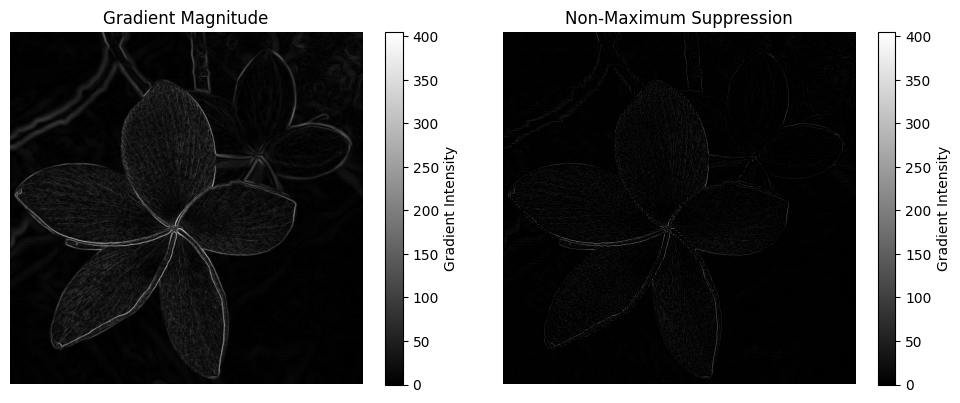

In [39]:
nms_image = np.zeros_like(magnitude)

# Define the window size
for i in range(1, magnitude.shape[0] - 1):
    for j in range(1, magnitude.shape[1] - 1):
        # Define the angle interval
        angle = direction[i, j] if direction[i, j] >= 0 else direction[i, j] + np.pi
        angle = np.rad2deg(angle)
        angle = angle % 180

        # Perform Non-Maximum Suppression
        if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
            prev = magnitude[i, j - 1]
            nxt = magnitude[i, j + 1]
        elif 22.5 <= angle < 67.5:
            prev = magnitude[i + 1, j - 1]
            nxt = magnitude[i - 1, j + 1]
        elif 67.5 <= angle < 112.5:
            prev = magnitude[i - 1, j]
            nxt = magnitude[i + 1, j]
        else:
            prev = magnitude[i - 1, j - 1]
            nxt = magnitude[i + 1, j + 1]

        if magnitude[i, j] >= prev and magnitude[i, j] >= nxt:
            nms_image[i, j] = magnitude[i, j]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(magnitude, cmap='gray')
plt.axis('off')
plt.title('Gradient Magnitude')
cbar = plt.colorbar()
cbar.set_label('Gradient Intensity')

plt.subplot(1, 2, 2)
plt.imshow(nms_image, cmap='gray')
plt.axis('off')
plt.title('Non-Maximum Suppression')
cbar = plt.colorbar()
cbar.set_label('Gradient Intensity')

plt.tight_layout()
plt.show()

### 4. Hysteresis Thresholding:

Next step is to apply hysteresis thresholding or also known as double thresholding. The algorithm uses two thresholds, a high threshold and a low threshold. All the points above the high threshold are considered to be strong edges and all the points below the low threshold are considered to be non-edges. The points between the two thresholds are considered to be weak edges. The algorithm then tracks the weak edges and checks if they are connected to strong edges. If they are connected to strong edges, they are considered to be edges. If they are not connected to strong edges, they are considered to be non-edges. This is done to remove the weak edges which are not connected to any of the strong edges.

Let:
- $ S $ denote the set of strong edges,
- $ W $ denote the set of weak edges,
- $ E(x, y) $ represent whether a pixel at \((x, y)\) is classified as an edge (\(1\)) or not (\(0\)).

The classification can be expressed as:

$$

E(x, y) =
\begin{cases} 
1, & \text{if } (x, y) \in S, \text{ or } (x, y) \in W \text{ and connected to } S, \\
0, & \text{otherwise.}
\end{cases}

$$

Connected to $S$ implies there exists a path from $(x, y)$ in $ W $ to some $(x', y')$ in $S$ that satisfies the connectivity criteria (e.g., adjacency).

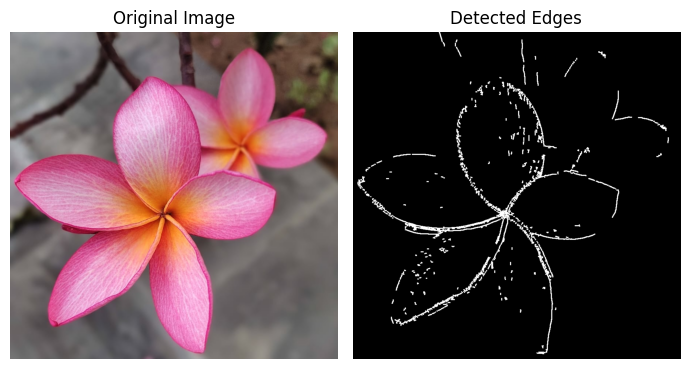

In [41]:
Edges = np.zeros_like(nms_image)

threshold_high = 100
threshold_low = 50
vicinity = 2

# Define the weak and strong edges
strong_edges = nms_image > threshold_high
weak_edges = (nms_image >= threshold_low) & (nms_image <= threshold_high)


# Define the edge map
Edges[strong_edges] = 255

# Define the weak edges that are connected to strong edges
for i in range(1, nms_image.shape[0] - 1):
    for j in range(1, nms_image.shape[1] - 1):
        if weak_edges[i, j]:
            if np.sum(strong_edges[i-vicinity:i+vicinity+1, j-vicinity:j+vicinity+1]) > 0:
                Edges[i, j] = 255

# Dilate the edges
Edges = cv.dilate(Edges, np.ones((3, 3), np.uint8), iterations=1)


# Display the Original Image and the Detected Edges
plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(Edges, cmap='gray')
plt.axis('off')
plt.title('Detected Edges')

plt.tight_layout()
plt.show()

The Final output is the edge image where the edges are detected. The edges are detected using the gradient information. The algorithm is very effective in detecting edges and is widely used in computer vision applications.